In [1]:
import mundi, mundi_demography

ModuleNotFoundError: No module named 'mundi_demography'

# Mundi data preparation

This notebook prepares data from various sources to be included as package compressed pickle files in the main Mundi distribution.

## Save list of countries from pycountry

In [379]:
df = pd.DataFrame([c._fields for c in pycountry.countries])
df = df.rename({'alpha_2': 'id', 'alpha_3': 'code', 'numeric': 'numeric_code'  }, axis=1)
df.index = df.pop('id').astype('<U2')
df['common_name'] = df['common_name'].fillna(df['name'])
df['official_name'] = df['official_name'].fillna(df['name'])
df = df[['name', 'code', 'numeric_code', 'official_name', 'common_name']]
df = df.astype('string')
df_countries = df

df.to_pickle(DATABASES / "countries.pkl.gz")
df

,name,code,numeric_code,official_name,common_name
id,,,,,
AW,Aruba,ABW,533,Aruba,Aruba
AF,Afghanistan,AFG,004,Islamic Republic of Afghanistan,Afghanistan
AO,Angola,AGO,024,Republic of Angola,Angola
AI,Anguilla,AIA,660,Anguilla,Anguilla
AX,Åland Islands,ALA,248,Åland Islands,Åland Islands
...,...,...,...,...,...
WS,Samoa,WSM,882,Independent State of Samoa,Samoa
YE,Yemen,YEM,887,Republic of Yemen,Yemen
ZA,South Africa,ZAF,710,Republic of South Africa,South Africa


## Sub-divisions

In [380]:
Row = namedtuple("Row", ["id", "name", "type", "parent"])
data = []
for c in pycountry.subdivisions:
    parent = c.parent_code.split('-')[1] if c.parent_code else c.country_code
    data.append(Row(tuple(c.code.split('-')), c.name, c.type.lower(), parent))

df = pd.DataFrame(data).astype({"name": "string", "parent": "string", "type": "category"})
df.index = pd.MultiIndex.from_tuples(df.pop("id"))
df_subdivisions = df

df

name      type parent
AD 02              Canillo    parish     AD
   03               Encamp    parish     AD
   04           La Massana    parish     AD
   05               Ordino    parish     AD
   06  Sant Julià de Lòria    parish     AD
...                    ...       ...    ...
ZW MI             Midlands  province     ZW
   MN   Matabeleland North  province     ZW
   MS   Matabeleland South  province     ZW
   MV             Masvingo  province     ZW
   MW     Mashonaland West  province     ZW

[4844 rows x 3 columns]

In [381]:
Row = namedtuple("Row", ["id", "name", "type", "parent"])
data = []
for c in pycountry.countries:
    data.append(Row((c.alpha_2, c.alpha_2), c.name, "country", None))

df = pd.DataFrame(data).astype({"name": "string", "parent": "string", "type": "category"})
df.index = pd.MultiIndex.from_tuples(df.pop("id"))
df = df_subdivisions = pd.concat([df_subdivisions, df]).sort_index()
df.loc["BR"]

,name,type,parent
AC,Acre,state,BR
AL,Alagoas,state,BR
AM,Amazonas,state,BR
AP,Amapá,state,BR
BA,Bahia,state,BR
BR,Brazil,country,<NA>
CE,Ceará,state,BR
DF,Distrito Federal,federal district,BR
ES,Espírito Santo,state,BR
FN,Fernando de Noronha,state,BR


## Brazillian sub-divisions

Later we may want to split it into codes for different countries and from different data sources. When that happens, we probably will want to change the data frame store to some querHDF5 or sqlite.

In [312]:
states = {x[0]: code for code, x in df.loc['BR'][['name']].iterrows()}

# Read raw data from IBGE
br = pd.read_excel('../raw_data/RELATORIO_DTB_BRASIL_DISTRITO.xls')
br.columns = ["state", "state_name", "meso_code", "meso_name", "micro_code", "micro_name", "city_short_code", "city_code", "city_name", "district_short_code", "district_code", "district_name"]
br["state_code"] = br["state"]
br["state"] = br["state_name"].apply(states.__getitem__)

# Collect dataframes
cols = ['id', 'name', 'type', 'parent']
Row = namedtuple('Row', cols)

# Regions
meso = set()
micro = set()
city = set()
district = set()

for _, row in br.iterrows():
    meso_id = f'{row.state_code}{row.meso_code:02}'
    micro_id = f'{meso_id}{row.micro_code:02}'
    city_id = str(row.city_code)[:-1]  # strip unused last digit
    district_id = str(row.district_code)
    
    meso.add(Row(('BR', meso_id), row.meso_name, 'geographic region', str(row.state)))
    micro.add(Row(('BR', micro_id), row.micro_name, 'region', meso_id))
    city.add(Row(('BR', city_id), row.city_name, 'municipality', micro_id))
    district.add(Row(('BR', district_id), row.district_name, 'district', city_id))
    
def mk_table(data):
    df = pd.DataFrame(list(data), columns=cols)
    df.index = pd.MultiIndex.from_tuples(df.pop("id"), names=['country', 'id'])
    df["name"] = df["name"].astype("string")
    df["parent"] = df["parent"].astype("string")
    df["type"] = df["type"].astype("string")
    
    return df
    
br_meso = mk_table(meso)
br_micro = mk_table(micro)
br_city = mk_table(city)
br_district = mk_table(district)

df = pd.concat([df_subdivisions, br_meso, br_micro, br_city, br_district])
df["type"] = df["type"].astype("category")

print(df.memory_usage(deep=True) / 1e6, len(df))
df_subdivisions = df

Index     1.904418
name      0.172840
type      0.030595
parent    0.172840
dtype: float64 21605


In [338]:
df_subdivisions = df_subdivisions.sort_index()
df_subdivisions.to_pickle(DATABASES / "subdivisions.pkl.gz")
!ls ../mundi/databases/ -lha

total 256K
drwxr-xr-x 2 chips chips 4,0K abr 21 23:26 .
drwxr-xr-x 4 chips chips 4,0K abr 21 23:09 ..
-rw-r--r-- 1 chips chips 6,4K abr 22 11:23 countries.pkl.gz
-rw-r--r-- 1 chips chips 2,5K abr 21 23:09 extra.pkl.gz
-rw-r--r-- 1 chips chips 235K abr 22 11:37 subdivisions.pkl.gz


In [340]:
df_subdivisions

name      type parent
country id                                      
AD      02              Canillo    parish   <NA>
        03               Encamp    parish   <NA>
        04           La Massana    parish   <NA>
        05               Ordino    parish   <NA>
        06  Sant Julià de Lòria    parish   <NA>
...                         ...       ...    ...
ZW      MI             Midlands  province   <NA>
        MN   Matabeleland North  province   <NA>
        MS   Matabeleland South  province   <NA>
        MV             Masvingo  province   <NA>
        MW     Mashonaland West  province   <NA>

[21605 rows x 3 columns]

## Mundi extra

Construct data points in the mundi.extra package.

### UN Income level classifications

In [8]:
codes = lambda lst: [c.alpha_2 for c in lst]
empty = [None] * len(df_countries)
df = pd.DataFrame({
    "un_income_level": empty,
    "un_development_level": empty,
    "continent": empty,
}, index=df_countries.index)


# UN Income level
col = "un_income_level"
df.loc[codes(un.high_income_countries), col] = "high"
df.loc[codes(un.upper_middle_income_countries), col] = "upper-middle"
df.loc[codes(un.lower_middle_income_countries), col] = "lower-middle"
df.loc[codes(un.low_income_countries), col] = "low"
df[col] = df[col].astype(extra.UNIncomeCategory)


# UN Development level
col = "un_development_level"
df.loc[codes(un.developed_countries), col] = "developed"
df.loc[codes(un.transitional_countries), col] = "transitional"
df.loc[codes(un.developing_countries), col] = "developing"
df.loc[codes(un.least_developed_countries), col] = "least-developed"
df[col] = df[col].astype(extra.UNDevelopmentCategory)


# Continents
col = "continent"
cam = codes(un.mexico_and_central_america) + codes(un.least_developed_latin_america_and_caribbean)
del cam[cam.index("MX")]
df[col] = None
df.loc[codes(un.africa) + codes(un.least_developed_africa), col] = "Africa"
df.loc[codes(un.south_america), col] = "South America"
df.loc[cam, col] = "Central America"
df.loc[
    codes(un.developed_europe) 
    + codes(un.transitional_europe)
    + codes(un.transitional_commonwealth), col] = "Europe"
df.loc[["MX", *codes(un.north_america)], col] = "North America"
df.loc[codes(un.asia), col] = "Asia"


df.to_pickle(DATABASES / 'extra.pkl.gz', protocol=3)

## Plots 

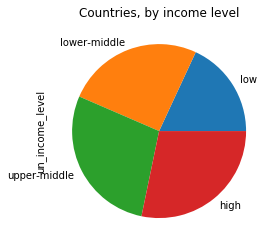

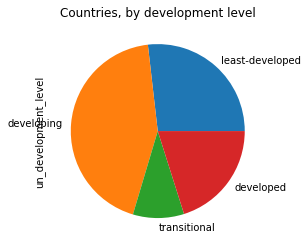

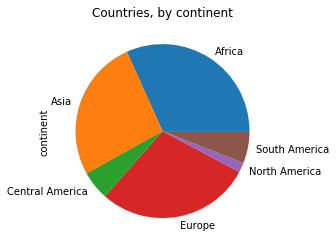

In [7]:
df.groupby("un_income_level")["un_income_level"].count().plot.pie()
plt.title("Countries, by income level")
plt.show()

df.groupby("un_development_level")["un_development_level"].count().plot.pie()
plt.title("Countries, by development level")
plt.show()

df.groupby("continent")["continent"].count().plot.pie()
plt.title("Countries, by continent")
plt.show()